In [122]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from env import TransitNetworkEnv
from logger import TrainingEpisodeLogger
from agent import Model, collect_rollout, ppo_update, fixed_policy
from tqdm import tqdm
from agent import *

In [123]:
def timetable_to_policy(env, timetable):
    """axis 0  is time and axis 1 is routes"""
    expanded_timetable = np.zeros((int(env.transit_system_config["hours_of_opperation_per_day"] * 3600
                                  / env.transit_system_config["analysis_period_sec"]),
                                  len(env.possible_agents)))

    for i in range(len(env.possible_agents)):
        per_period_deployments = []
        for j in range(env.transit_system_config["hours_of_opperation_per_day"]):
            deployments_per_hour = timetable[j, i]
            expanded_deployments = np.zeros(int(3600/env.transit_system_config["analysis_period_sec"]))
            for _ in range(int(deployments_per_hour)):
                ind = np.random.randint(0, expanded_deployments.shape[0])
                while expanded_deployments[ind] != 0:
                    ind = np.random.randint(0, expanded_deployments.shape[0])
                expanded_deployments[ind] = 1
            per_period_deployments.append(expanded_deployments)

        expanded_timetable[:, i] = np.concatenate(per_period_deployments)
    return expanded_timetable

def policy_to_action_at_time(policy, t, s):
    """TxA"""
    return {f"agent_{i}": a for i, a in enumerate(policy[int(t//s)])}

In [ ]:
def objective_ftn(env, policy):
    (
        reward_buf,
        terminated_buf,
        truncated_buf,
        info_buf,
    ) = (
        {agent_id: [] for agent_id in env.possible_agents},
        {agent_id: [] for agent_id in env.possible_agents},
        {agent_id: [] for agent_id in env.possible_agents},
        {agent_id: [] for agent_id in env.possible_agents},
    )

    killed_agents = set()
    sc = 0
    num_killed = 0
    for step_count in range(
        int(
            (env.transit_system_config["hours_of_opperation_per_day"] * 3600)
            / env.transit_system_config["analysis_period_sec"]
        )
    ):

        next_obs, reward, terminated, truncated, info = env.step(
            policy_to_action_at_time(
                policy,
                env.current_time,
                env.transit_system_config["analysis_period_sec"],
            )
        )
        for agent_id in env.possible_agents:
            if agent_id not in killed_agents:
                reward_buf[agent_id].append(
                    torch.tensor(reward[agent_id], dtype=torch.float32)
                )
                info_buf[agent_id].append(info[agent_id])
                terminated_buf[agent_id].append(terminated[agent_id])
                truncated_buf[agent_id].append(truncated[agent_id])

                if terminated[agent_id] or truncated[agent_id]:
                    if agent_id not in killed_agents:
                        killed_agents.add(agent_id)
                if terminated[agent_id]:
                    num_killed += 1
                    sc += step_count

        _ = next_obs
        if len(killed_agents) == len(env.possible_agents):
            break

        good_buses = 0
        for agent_id in env.possible_agents:
            T = len(reward_buf[agent_id])
            for t in reversed(range(T)):
                current_time = info_buf[agent_id][t]["current_time"]
                additional_reward = None
                for i in range(t, T):
                    retired_buses = info_buf[agent_id][i]["retired_buses"]
                    for bus in retired_buses:
                        if bus.created_at == current_time:
                            if bus.num_passengers_served / bus.capacity > 0.90:
                                additional_reward = 4
                            elif bus.num_passengers_served / bus.capacity > 0.50:
                                additional_reward = 2
                            elif bus.num_passengers_served / bus.capacity > 0.10:
                                additional_reward = 0
                            elif bus.num_passengers_served / bus.capacity > 0.0:
                                additional_reward = -2
                            else:
                                additional_reward = -4
                            break

                    if additional_reward is not None:
                        reward_buf[agent_id][t] += additional_reward
                        info_buf[agent_id][t]["reward_type_3"] += additional_reward
                        good_buses += 1
                        break

    return np.array(
        [
            sum(
                [info_buf[agent_id][t]["reward_type_3"] for t in range(policy.shape[0])]
            )
            + sum(
                [info_buf[agent_id][t]["reward_type_2"] for t in range(policy.shape[0])]
            )
            for agent_id in env.possible_agents
        ]
    )


def run_simulated_anealing(seed=0):
    env = TransitNetworkEnv({"is_training": True, "seed": seed})
    _, _ = env.reset(hard_reset=True)

    obj_history = []
    timetable = (
        np.ones(
            (
                env.transit_system_config["hours_of_opperation_per_day"],
                len(env.possible_agents),
            )
        )
        * 1
    )

    old_objective = np.full(
        len(env.possible_agents),
        -np.inf,
    )

    final_timetable = timetable.copy()

    for _ in (range(100)):
        env = TransitNetworkEnv({"is_training": True, "seed": seed})
        _, _ = env.reset(hard_reset=True)
        policy = timetable_to_policy(env, timetable.copy())
        objective = objective_ftn(env, policy)

        for i in range(objective.shape[0]):
            if objective[i] > old_objective[i]:
                old_objective[i] = objective[i]
                final_timetable[:, i] = timetable[:, i]
            else:
                timetable[:, i] = final_timetable[:, i]
                
        obj_history.append(old_objective.copy())
        
        for i in range(objective.shape[0]):
            j = np.random.randint(timetable.shape[0])
            timetable[j, i] += 1
    
    return final_timetable, obj_history

In [ ]:
all_tts = {}
for seed in [828920903,
             115601515,
             989005593,  
             267626564, 
             913751312, 
             398943963, 
             436715962, 
             624311666, 
             433623492]:
    
    final_timetable, obj_history = run_simulated_anealing(seed=seed)
    all_tts[seed] = final_timetable
    print(seed, "completed")

 50%|█████     | 50/100 [47:50<47:50, 57.41s/it]


KeyboardInterrupt: 

In [93]:
# env = TransitNetworkEnv({"is_training": True, "seed": 0}) 
# _, _ = env.reset(hard_reset=True)
# t = env.transit_system.topology.show_report()

In [116]:
d[0].sum(axis=0).mean()

21.4

In [120]:
d[-1][-1]

array([1105.63948413,  504.79423611, 1800.71444444, 1256.35805556,
        587.58263889,  618.37256944, 1207.96664683,  930.35923611,
        810.82465278, 1169.29361111])

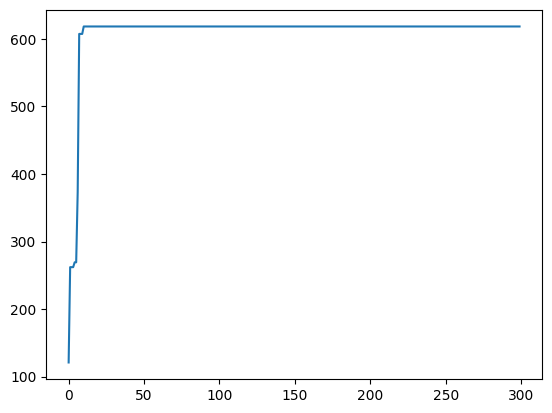

In [117]:
plt.plot(np.array(d[-1])[:, 5])